<a href="https://colab.research.google.com/github/Emma-Ok/Phishing-Detection-ML/blob/alc4dev/ModelsWithAllSamples/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [optuna]2m1/2 [optuna]


In [3]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix, 
                           ConfusionMatrixDisplay, roc_curve, auc, f1_score, accuracy_score,
                           precision_score, recall_score, matthews_corrcoef, make_scorer)
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Carga directa desde GitHub
url = "https://raw.githubusercontent.com/Emma-Ok/Phishing-Detection-ML/main/Phishing_Legitimate_full.csv"
df = pd.read_csv(url)
df = df.drop(columns=['id'])

print(f"Dataset shape: {df.shape}")
print(f"Distribución de clases:\n{df['CLASS_LABEL'].value_counts()}")

# Separar X e y
X = df.drop(columns=['CLASS_LABEL'])
y = df['CLASS_LABEL']

# División estratificada según metodología: 70% train, 15% val, 15% test

# Primera división: separar test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=42, 
    stratify=y
)

# Segunda división: separar train (70%) y validation (15%) del restante 85%
# 15/85 = 0.176 para obtener 15% del total original
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.176, 
    random_state=42, 
    stratify=y_temp
)

print(f"Tamaños de conjuntos:")
print(f"Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")


Dataset shape: (10000, 49)
Distribución de clases:
CLASS_LABEL
1    5000
0    5000
Name: count, dtype: int64
Tamaños de conjuntos:
Train: 7004 (70.0%)
Validation: 1496 (15.0%)
Test: 1500 (15.0%)


In [4]:
# Definir el pipeline fijo (el scaler no se optimiza)
def create_pipeline(n_neighbors, weights, metric, p):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,
            metric=metric,
            p=p if metric == 'minkowski' else 2  # p solo aplica a minkowski
        ))
    ])

# Estrategia de validación
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Función objetivo para Optuna
def objective(trial):
    n_neighbors = trial.suggest_categorical('n_neighbors', [3, 5, 7, 9, 11, 15, 21])
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    p = trial.suggest_categorical('p', [1, 2]) if metric == 'minkowski' else 2

    pipeline = create_pipeline(n_neighbors, weights, metric, p)

    scores = cross_val_score(
        pipeline,
        X_train, y_train,
        scoring=make_scorer(f1_score),
        cv=stratified_kfold,
        n_jobs=-1
    )
    return scores.mean()

# Crear estudio y optimizar
study = optuna.create_study(direction='maximize')
print("Iniciando optimización con Optuna...")
study.optimize(objective, n_trials=50)  # Puedes ajustar el número de pruebas

# Resultados
print(f"\nMejores parámetros encontrados: {study.best_params}")
print(f"Mejor F1-score en CV: {study.best_value:.4f}")

# Entrenar modelo final con mejores parámetros
best_params = study.best_params
final_pipeline = create_pipeline(
    best_params['n_neighbors'],
    best_params['weights'],
    best_params['metric'],
    best_params.get('p', 2)
)

final_pipeline.fit(X_train, y_train)

Iniciando optimización con Optuna...

Mejores parámetros encontrados: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}
Mejor F1-score en CV: 0.9587


Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=3,
                                      weights='distance'))])

In [5]:
# EVALUACIÓN EN CONJUNTO DE VALIDACIÓN (Fase de validación según metodología)
print("\n=== EVALUACIÓN EN CONJUNTO DE VALIDACIÓN ===")

# Predecir
y_val_pred = final_pipeline.predict(X_val)
y_val_proba = final_pipeline.predict_proba(X_val)[:, 1]

# Métricas
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_proba)
val_mcc = matthews_corrcoef(y_val, y_val_pred)

# Specificity
cm_val = confusion_matrix(y_val, y_val_pred)
val_specificity = cm_val[0, 0] / (cm_val[0, 0] + cm_val[0, 1])

print("Métricas en Validación:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall (Sensitivity): {val_recall:.4f}")
print(f"Specificity: {val_specificity:.4f}")
print(f"F1-Score: {val_f1:.4f}")
print(f"AUC-ROC: {val_auc:.4f}")
print(f"Matthews Correlation Coefficient: {val_mcc:.4f}")

# EVALUACIÓN FINAL EN CONJUNTO DE PRUEBA (Fase de prueba según metodología)
print("\n=== EVALUACIÓN FINAL EN CONJUNTO DE PRUEBA ===")

# Predecir
y_test_pred = final_pipeline.predict(X_test)
y_test_proba = final_pipeline.predict_proba(X_test)[:, 1]

# Métricas
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)
test_mcc = matthews_corrcoef(y_test, y_test_pred)

# Specificity
cm_test = confusion_matrix(y_test, y_test_pred)
test_specificity = cm_test[0, 0] / (cm_test[0, 0] + cm_test[0, 1])

print("Métricas en Prueba:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall (Sensitivity): {test_recall:.4f}")
print(f"Specificity: {test_specificity:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"AUC-ROC: {test_auc:.4f}")
print(f"Matthews Correlation Coefficient: {test_mcc:.4f}")

print(f"\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Legítimo', 'Phishing']))




=== EVALUACIÓN EN CONJUNTO DE VALIDACIÓN ===
Métricas en Validación:
Accuracy: 0.9599
Precision: 0.9479
Recall (Sensitivity): 0.9733
Specificity: 0.9465
F1-Score: 0.9604
AUC-ROC: 0.9805
Matthews Correlation Coefficient: 0.9201

=== EVALUACIÓN FINAL EN CONJUNTO DE PRUEBA ===
Métricas en Prueba:
Accuracy: 0.9667
Precision: 0.9534
Recall (Sensitivity): 0.9813
Specificity: 0.9520
F1-Score: 0.9671
AUC-ROC: 0.9862
Matthews Correlation Coefficient: 0.9337

Classification Report (Test):
              precision    recall  f1-score   support

    Legítimo       0.98      0.95      0.97       750
    Phishing       0.95      0.98      0.97       750

    accuracy                           0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500



In [32]:


print("\n=== EVALUACIÓN DE CRITERIOS DE SELECCIÓN ===")

# Criterio 1: F1-score maximizado en CV ✓ (ya cumplido por Optuna)
print(f"✓ F1-score optimizado en CV: {cv_mean:.4f}")

# Criterio 2: AUC-ROC ≥ 0.90 en conjunto de validación
auc_criterion = val_auc >= 0.90
status = "✓" if auc_criterion else "✗"
print(f"{status} AUC-ROC ≥ 0.90 (Validación): {val_auc:.4f}")

# Criterio 3: Estabilidad entre folds (CV ≤ 5%)
stability_criterion = cv_coefficient <= 0.05
status = "✓" if stability_criterion else "✗"
print(f"{status} Estabilidad entre folds (CV ≤ 5%): {cv_coefficient * 100:.2f}%")

# Criterio 4: Generalización adecuada (|F1_val - F1_test| ≤ 5%)
f1_diff = abs(val_f1 - test_f1)
generalization_criterion = f1_diff <= 0.05
status = "✓" if generalization_criterion else "✗"
print(f"{status} Generalización adecuada (diff F1 ≤ 5%): {f1_diff * 100:.2f}%")




=== EVALUACIÓN DE CRITERIOS DE SELECCIÓN ===
✓ F1-score optimizado en CV: 0.9587
✓ AUC-ROC ≥ 0.90 (Validación): 0.9805
✓ Estabilidad entre folds (CV ≤ 5%): 0.62%
✓ Generalización adecuada (diff F1 ≤ 5%): 0.67%


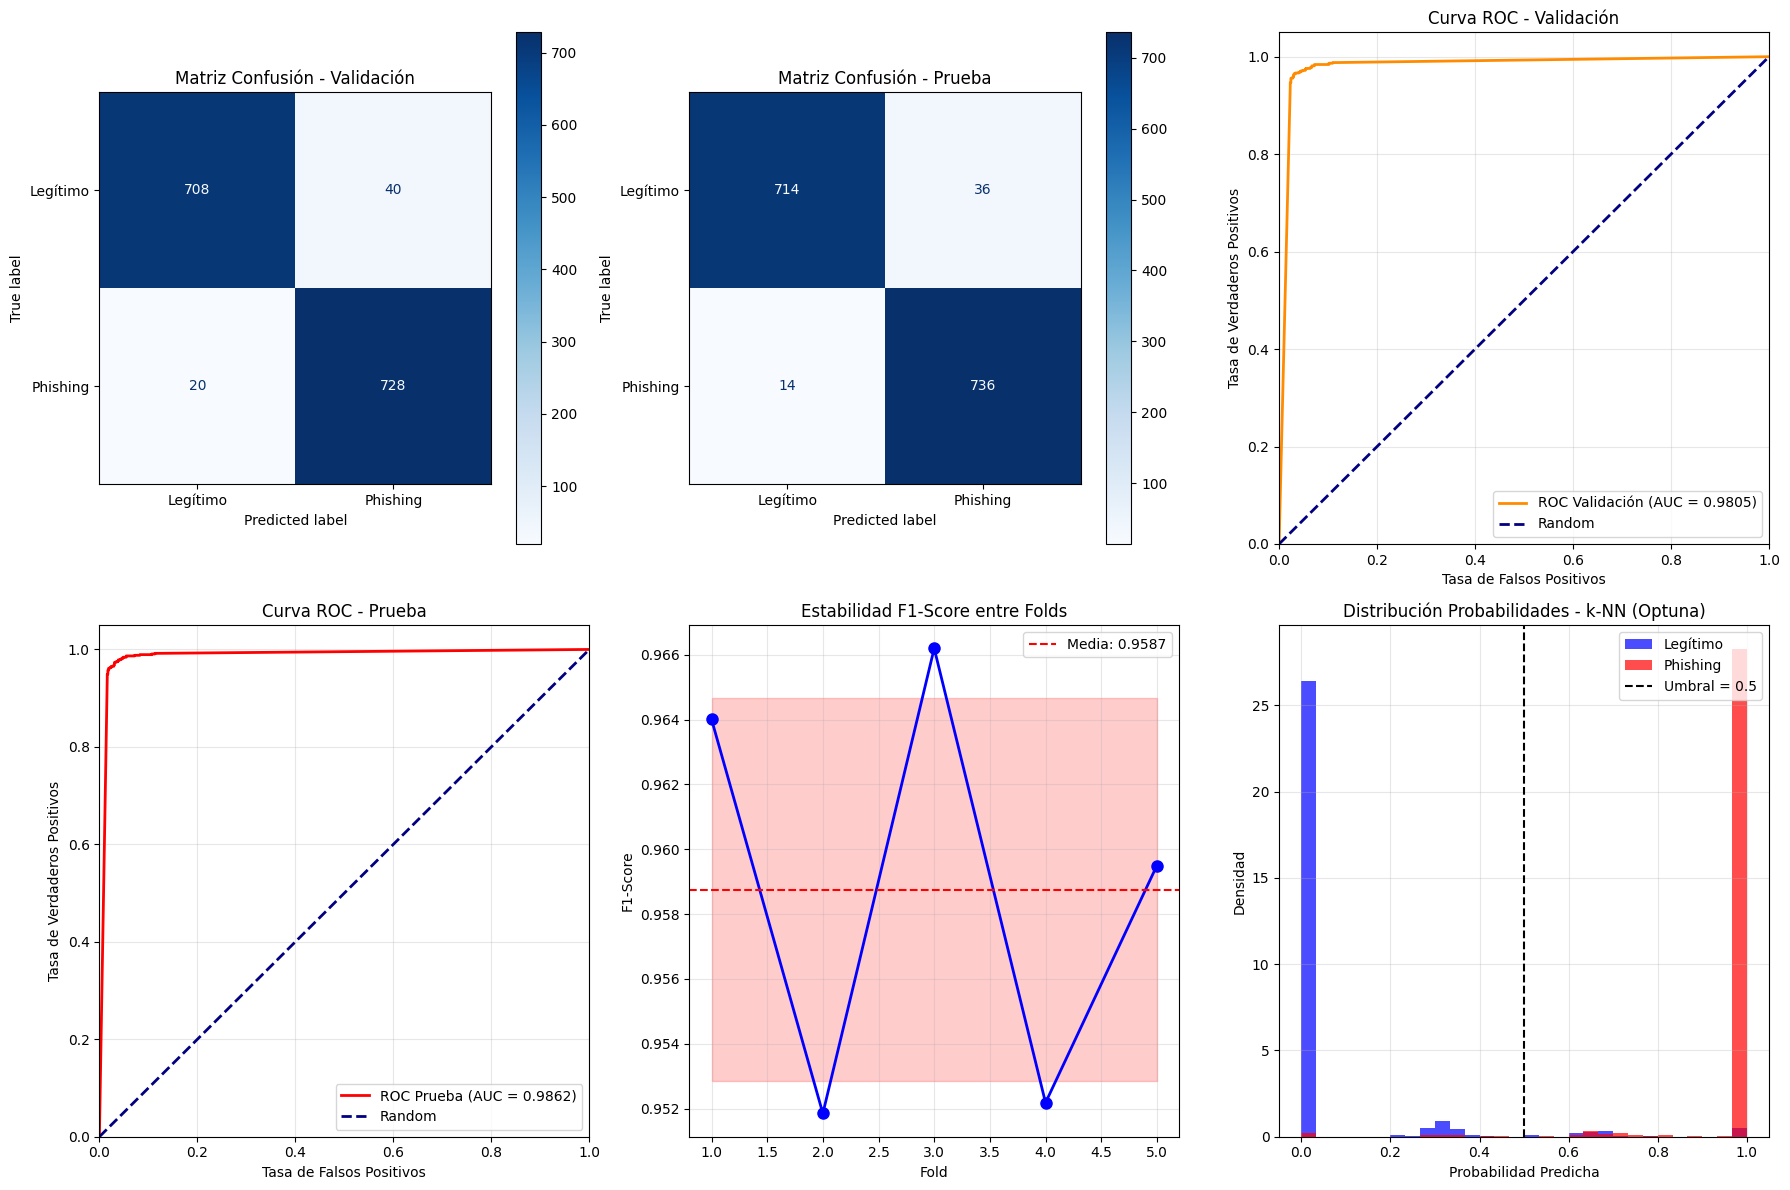

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Matriz de confusión - Validación
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['Legítimo', 'Phishing'])
disp_val.plot(ax=axes[0,0], cmap='Blues', values_format='d')
axes[0,0].set_title('Matriz Confusión - Validación')

# 2. Matriz de confusión - Prueba
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Legítimo', 'Phishing'])
disp_test.plot(ax=axes[0,1], cmap='Blues', values_format='d')
axes[0,1].set_title('Matriz Confusión - Prueba')

# 3. Curva ROC - Validación
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
roc_auc_val = auc(fpr_val, tpr_val)
axes[0,2].plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'ROC Validación (AUC = {roc_auc_val:.4f})')
axes[0,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0,2].set_xlim([0.0, 1.0])
axes[0,2].set_ylim([0.0, 1.05])
axes[0,2].set_xlabel('Tasa de Falsos Positivos')
axes[0,2].set_ylabel('Tasa de Verdaderos Positivos')
axes[0,2].set_title('Curva ROC - Validación')
axes[0,2].legend(loc="lower right")
axes[0,2].grid(alpha=0.3)

# 4. Curva ROC - Prueba
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)
axes[1,0].plot(fpr_test, tpr_test, color='red', lw=2, label=f'ROC Prueba (AUC = {roc_auc_test:.4f})')
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1,0].set_xlim([0.0, 1.0])
axes[1,0].set_ylim([0.0, 1.05])
axes[1,0].set_xlabel('Tasa de Falsos Positivos')
axes[1,0].set_ylabel('Tasa de Verdaderos Positivos')
axes[1,0].set_title('Curva ROC - Prueba')
axes[1,0].legend(loc="lower right")
axes[1,0].grid(alpha=0.3)

# 5. Estabilidad entre folds
axes[1,1].plot(range(1, 6), fold_scores, 'bo-', linewidth=2, markersize=8)
axes[1,1].axhline(y=cv_mean, color='r', linestyle='--', label=f'Media: {cv_mean:.4f}')
axes[1,1].fill_between(range(1, 6), cv_mean - cv_std, cv_mean + cv_std, alpha=0.2, color='red')
axes[1,1].set_xlabel('Fold')
axes[1,1].set_ylabel('F1-Score')
axes[1,1].set_title('Estabilidad F1-Score entre Folds')
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

# 6. Distribución de probabilidades (en prueba)
axes[1,2].hist(y_test_proba[y_test == 0], bins=30, alpha=0.7, label='Legítimo', color='blue', density=True)
axes[1,2].hist(y_test_proba[y_test == 1], bins=30, alpha=0.7, label='Phishing', color='red', density=True)
axes[1,2].axvline(x=0.5, color='black', linestyle='--', label='Umbral = 0.5')
axes[1,2].set_xlabel('Probabilidad Predicha')
axes[1,2].set_ylabel('Densidad')
axes[1,2].set_title('Distribución Probabilidades - k-NN (Optuna)')
axes[1,2].legend()
axes[1,2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [33]:
print("\n=== ANÁLISIS DE OPTUNA ===")
print("Top 5 combinaciones de hiperparámetros (Optuna):")
top_trials = study.trials_dataframe().sort_values("value", ascending=False).head(5)
for i, row in top_trials.iterrows():
    params = {k.replace("params_", ""): row[k] for k in row.index if k.startswith("params_")}
    print(f"F1: {row['value']:.4f} - {params}")


# Análisis por hiperparámetro
print("\n=== ANÁLISIS POR HIPERPARÁMETRO ===")

df_trials = study.trials_dataframe()

# Análisis por número de vecinos
neighbor_analysis = df_trials.groupby('params_n_neighbors')['value'].agg(['mean', 'std'])
print("Rendimiento por número de vecinos:")
print(neighbor_analysis.sort_values('mean', ascending=False))

# Análisis por tipo de peso
weights_analysis = df_trials.groupby('params_weights')['value'].agg(['mean', 'std'])
print("\nRendimiento por tipo de peso:")
print(weights_analysis.sort_values('mean', ascending=False))

# Análisis por métrica
metric_analysis = df_trials.groupby('params_metric')['value'].agg(['mean', 'std'])
print("\nRendimiento por métrica de distancia:")
print(metric_analysis.sort_values('mean', ascending=False))

# Resumen general del modelo
print("\n=== RESUMEN PARA COMPARACIÓN DE MODELOS ===")
print("k-Nearest Neighbors (Optuna):")
print(f"  CV F1-Score: {cv_mean:.4f} (±{cv_std:.4f})")
print(f"  Validation F1-Score: {val_f1:.4f}")
print(f"  Test F1-Score: {test_f1:.4f}")
print(f"  Validation AUC-ROC: {val_auc:.4f}")
print(f"  Test AUC-ROC: {test_auc:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f}")
print(f"  Mejores hiperparámetros: {best_trial.params}")



# Análisis de generalización detallado
print("\n=== ANÁLISIS DE GENERALIZACIÓN ===")
f1_diff = val_f1 - test_f1
auc_diff = val_auc - test_auc
print(f"Diferencia F1 (Validación - Prueba): {f1_diff:.4f}")
print(f"Diferencia AUC (Validación - Prueba): {auc_diff:.4f}")

if abs(f1_diff) < 0.03:
    print("✓ Excelente generalización (diferencia F1 < 0.03)")
elif abs(f1_diff) < 0.05:
    print("✓ Buena generalización (diferencia F1 < 0.05)")
else:
    print("⚠ Posible overfitting o underfitting (diferencia F1 ≥ 0.05)")

# Guardar resultados del modelo
knn_results = {
    'model_name': 'k-Nearest Neighbors (Optuna)',
    'best_params': best_trial.params,
    'cv_f1_mean': cv_mean,
    'cv_f1_std': cv_std,
    'cv_stability': cv_coefficient,
    'val_f1': val_f1,
    'val_auc': val_auc,
    'val_accuracy': val_accuracy,
    'val_precision': val_precision,
    'val_recall': val_recall,
    'val_specificity': val_specificity,
    'val_mcc': val_mcc,
    'test_f1': test_f1,
    'test_auc': test_auc,
    'test_accuracy': test_accuracy,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_specificity': test_specificity,
    'test_mcc': test_mcc,
    'criteria_met': all_criteria
}



=== ANÁLISIS DE OPTUNA ===
Top 5 combinaciones de hiperparámetros (Optuna):
F1: 0.9587 - {'metric': 'minkowski', 'n_neighbors': 3, 'p': 1.0, 'weights': 'distance'}
F1: 0.9587 - {'metric': 'minkowski', 'n_neighbors': 3, 'p': 1.0, 'weights': 'distance'}
F1: 0.9587 - {'metric': 'manhattan', 'n_neighbors': 3, 'p': nan, 'weights': 'distance'}
F1: 0.9587 - {'metric': 'minkowski', 'n_neighbors': 3, 'p': 1.0, 'weights': 'distance'}
F1: 0.9587 - {'metric': 'minkowski', 'n_neighbors': 3, 'p': 1.0, 'weights': 'distance'}

=== ANÁLISIS POR HIPERPARÁMETRO ===
Rendimiento por número de vecinos:
                        mean       std
params_n_neighbors                    
3                   0.956297  0.001769
5                   0.952505  0.002839
11                  0.947298  0.009502
9                   0.946801  0.008030
7                   0.946341  0.001681
21                  0.943648  0.006321
15                  0.942530  0.006017

Rendimiento por tipo de peso:
                    mean     